In [4]:
import tensorflow as tf
import numpy as np
import mdn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from timeit import default_timer as timer
import xgboost as xgb

bin_count = 151

In [2]:
def find_first_zero(row):
    vals = list(row) 
  
    last_zero_index = -1
    for idx, val in enumerate(reversed(vals)): 
        if val > 0:
            last_zero_index = bin_count - idx
            break
    return last_zero_index

def create_test_train(data_set_path, test_size=0.10):
    """ Splits a given csv file into testing and training. Target column is all the bins. Add a c """
    # Make sure the columns are set
    data_set = pd.read_csv(data_set_path)

    # Add column for classifying whether the output has most of the data in the last 10 bins.
    end_average = data_set[[f'Output_Bin_{i}' for i in range(bin_count-10, bin_count)]].sum(axis=1) > 0.9

    data_set['Output_Is_End'] = end_average
    data_set['Output_Is_End'] = data_set['Output_Is_End'].astype(int)
    #data_set['Output_Is_Not_End'] = ~data_set['Output_Is_End']
    
    

    data_set['Output_First_Zero'] = data_set[[f'Output_Bin_{i}' for i in range(bin_count)]].apply(find_first_zero, axis=1)

    # Shuffle the data
    data_set = data_set.sample(frac=1, random_state=0)
 
    # Select all except output bins
    data_set_X = data_set.drop([f'Output_Bin_{i}' for i in range(bin_count)] + ['Output_Is_End', 'Output_First_Zero'], axis=1)
    # Select only the output bins
    data_set_Y = data_set[[f'Output_Bin_{i}' for i in range(bin_count)]+ ['Output_Is_End', 'Output_First_Zero']]

    #Split into training and test data
    return train_test_split(data_set_X,
                            data_set_Y,
                            test_size=test_size, 
                            random_state=300)

#filename = "/scratch/keh4nb/dust_training_data_all_bins_large.csv"
filename= "/project/SDS-capstones-kropko21/uva-astronomy/dust_training_data_all_bins.csv"
X_train, X_test, y_train, y_test = create_test_train(filename, test_size=0.10)
display(y_test.describe())

,Output_Bin_0,Output_Bin_1,Output_Bin_2,Output_Bin_3,Output_Bin_4,Output_Bin_5,Output_Bin_6,Output_Bin_7,Output_Bin_8,Output_Bin_9,...,Output_Bin_143,Output_Bin_144,Output_Bin_145,Output_Bin_146,Output_Bin_147,Output_Bin_148,Output_Bin_149,Output_Bin_150,Output_Is_End,Output_First_Zero
count,80034.000000,80034.000000,80034.000000,80034.000000,80034.000000,80034.000000,80034.000000,80034.000000,8.003400e+04,8.003400e+04,...,80034.000000,80034.000000,80034.000000,8.003400e+04,80034.000000,80034.000000,80034.000000,80034.000000,80034.000000,80034.000000
mean,0.004592,0.003381,0.002994,0.003368,0.003351,0.003394,0.003532,0.003670,3.814056e-03,3.911485e-03,...,0.001006,0.000848,0.000703,6.984170e-04,0.001683,0.004521,0.013961,0.232077,0.245646,110.308256
std,0.011374,0.007610,0.006414,0.008043,0.006695,0.006400,0.006739,0.006520,7.153507e-03,6.694352e-03,...,0.005998,0.005194,0.004531,4.395189e-03,0.005804,0.011810,0.034216,0.398182,0.430472,35.159546
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.265408e-28,1.791201e-26,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,81.000000
50%,0.000104,0.000118,0.000131,0.000172,0.000208,0.000239,0.000276,0.000337,4.037371e-04,4.756950e-04,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,111.000000
75%,0.002556,0.002411,0.002417,0.002877,0.003221,0.003548,0.003946,0.004411,4.805814e-03,5.215707e-03,...,0.000000,0.000000,0.000000,2.250088e-16,0.000010,0.000021,0.000020,0.556202,0.000000,151.000000
max,0.091789,0.056024,0.044559,0.397845,0.149386,0.037269,0.271610,0.037480,3.060384e-01,1.159124e-01,...,0.081785,0.083285,0.084418,8.594993e-02,0.099890,0.130261,0.238778,1.000000,1.000000,151.000000


Try xgboost for predicting whether all the particles are at the end of the distribution. Ended up getting over 99% test accuracy.

In [34]:
#%pip install xgboost
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", 
                              random_state=42)
xgb_model.fit(X_train, y_train['Output_Is_End'],
             eval_set=[(X_train, y_train['Output_Is_End']), (X_test, y_test['Output_Is_End'])],
             eval_metric='error',verbose=True)

evals_result = xgb_model.evals_result()

[0]	validation_0-error:0.01501	validation_1-error:0.01493
[1]	validation_0-error:0.01274	validation_1-error:0.01280
[2]	validation_0-error:0.01139	validation_1-error:0.01179
[3]	validation_0-error:0.00999	validation_1-error:0.01031
[4]	validation_0-error:0.00920	validation_1-error:0.00993
[5]	validation_0-error:0.00865	validation_1-error:0.00927
[6]	validation_0-error:0.00782	validation_1-error:0.00843
[7]	validation_0-error:0.00744	validation_1-error:0.00793
[8]	validation_0-error:0.00684	validation_1-error:0.00738
[9]	validation_0-error:0.00630	validation_1-error:0.00680
[10]	validation_0-error:0.00600	validation_1-error:0.00656
[11]	validation_0-error:0.00572	validation_1-error:0.00632
[12]	validation_0-error:0.00547	validation_1-error:0.00609
[13]	validation_0-error:0.00505	validation_1-error:0.00562
[14]	validation_0-error:0.00454	validation_1-error:0.00527
[15]	validation_0-error:0.00442	validation_1-error:0.00522
[16]	validation_0-error:0.00406	validation_1-error:0.00497
[17]	va

In [36]:
preds = xgb_model.predict(X_test)

# Count the number of matches between predictions and labels
correct = np.sum(preds == y_test['Output_Is_End'])

# Calculate accuracy
accuracy = correct / len(y_test)
print(f"Accuracy: {accuracy}")

xgb_model.save_model('xgb_model_is_end.model')

Accuracy: 0.998813004473099


Train a linear regression model for predicting when first zero occurs on models where the dust is not all stacked at the end.

In [ ]:

xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
                             eta=0.1,
                             n_estimators=1000,
                             sub_sample=0.8,
                             colsample_bytree=0.8,
                             max_depth=8,
                              random_state=42)


# Only train on output not at end
output_not_end_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 0]
X_first_zero = X_train.loc[output_not_end_idx]
y_first_zero = y_train.loc[output_not_end_idx, 'Output_First_Zero']

xgb_model.fit(X_first_zero, y_first_zero,
             eval_set=[(X_first_zero, y_first_zero)],
             eval_metric='rmse', early_stopping_rounds=10, verbose=True)

evals_result = xgb_model.evals_result()

Best train result is 1.116 RMSE. Best test RMSE is 1.3

In [6]:
from sklearn.metrics import mean_squared_error as MSE 

#Optionally load pretrained model
# Load first zero model
#xgb_model = xgb.XGBRegressor()
#xgb_model.load_model('xgb_model_first_zero.model')

# Only predict on output not at end
output_not_end_test_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 0]
X_test_first_zero = X_test.loc[output_not_end_test_idx]
y_test_first_zero = y_test.loc[output_not_end_test_idx, 'Output_First_Zero']

# Predict the model. Round preds since bins are whole numbers
pred = np.rint(xgb_model.predict(X_test_first_zero)) 
  
# RMSE Computation 
rmse = np.sqrt(MSE(y_test_first_zero, pred)) 
print(f"RMSE : {rmse}") 

pd.set_option('display.max_rows', None)
print(pd.DataFrame({"preds":pred, "test":y_test_first_zero}).head(25))

RMSE : 1.3883092322193251
        preds  test
509706  108.0   108
280992  133.0   133
589362  101.0   100
100403   99.0    99
569818  102.0   102
747556   60.0    60
162103  149.0   149
763711   38.0    31
175986  147.0   147
773247   40.0    46
599540   71.0    71
196468  119.0   117
728162   60.0    60
794035   77.0    77
429222  116.0   116
622139  127.0   127
460440  121.0   121
96798    99.0    99
662134   90.0    90
229566   87.0    86
520709   83.0    84
614446   72.0    72
577202  101.0   101
198813   86.0    86
657359  106.0   107


In [33]:
xgb_model.save_model('xgb_model_first_zero.model')

Train two MDNs, one on the dust at end and one without

In [5]:
def build_mdn_model(activation='sigmoid', k=16):
    """ k is the number of mixture models"""
    # Number of columns (bin count plus 8 inputs)
    l = bin_count + 8

    # Network
    input = tf.keras.Input(shape=(l,))

    layer = tf.keras.layers.Dense(256, activation=activation, name='baselayer')(input)
    layer_2 = tf.keras.layers.Dense(128, activation=activation, name='layer_2')(layer)

    # Connect the mdn layer to the output of our neural network
    mdn_layer = mdn.MDN(bin_count,k, name='mdn')(layer_2)
    model = tf.keras.models.Model(input, [mdn_layer])


    opt = tf.keras.optimizers.Adam(learning_rate=1e4)
    model.compile(loss=mdn.get_mixture_loss_func(bin_count,k), optimizer=tf.keras.optimizers.Adam())
    model.summary()
    return model

Build a mdn model for the outputs where the dust is at the end of the distribution

In [7]:
model_spike = build_mdn_model(k=64)
output_is_end_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 1]

X = X_train.loc[output_is_end_idx]
y = y_train.loc[output_is_end_idx].drop(['Output_Is_End', 'Output_First_Zero'], axis=1)
print(y.shape)
spike_fit = model_spike.fit(x=X, y=y, batch_size=256, epochs=75, validation_split=0.1, callbacks=[tf.keras.callbacks.TerminateOnNaN()])

Model: "functional_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 159)]             0         
_________________________________________________________________
baselayer (Dense)            (None, 256)               40960     
_________________________________________________________________
layer_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
mdn (MDN)                    (None, 19392)             2501568   
Total params: 2,575,424
Trainable params: 2,575,424
Non-trainable params: 0
_________________________________________________________________
(176325, 151)
Epoch 1/75
620/620 [==============================] - 30s 49ms/step - loss: -354.2905 - val_loss: -393.7363
Epoch 2/75
620/620 [==============================] - 23s 38ms/step - loss: -382.4264 - val_loss: -485.1568
Epoch 3/75
6

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
model_spike.save("spiked_mdn_model/model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: spiked_mdn_model/model/assets


In [6]:
from scipy.stats import entropy
def predict_for_test(model, X_test, y_test, k):

    start = timer()

    # Returns the predictions of the parameters of the distributions and weights
    preds = model.predict(X_test)
    samples_list = []
    # Obtain 5 samples per prediction
    for i in range(5):
        samples_list.append(np.apply_along_axis(mdn.sample_from_output, 1, preds, bin_count, k, temp=1.0, sigma_temp=1.0))

    # Average the samples for our predicitons
    y_samples = np.mean(np.array(samples_list),axis=0)
    y_samples = y_samples.reshape(len(X_test),bin_count)
    # Convert negatives to 0
    y_samples = np.clip(y_samples,0, a_max=None)
    end = timer()
    
    print(f"Total time taken: {end-start}. Seconds per prediction: {(end-start)/len(preds)}")
    
    return y_samples

Make predictions for this model and evaluate the results

In [7]:
output_is_end_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 1]

X_test_spike = X_test.loc[output_is_end_idx]
y_test_spike = y_test.loc[output_is_end_idx].drop(['Output_Is_End','Output_First_Zero'], axis=1)

spike_preds = predict_for_test(model_spike, X_test_spike, y_test_spike, 16)

Total time taken: 226.4551142314449. Seconds per prediction: 0.011518571425811032


In [19]:
from scipy.stats import entropy
def evaluate_fit(y_samples, y_test):
    ent = []

    # Turn all negative preds to 0
    y_samples = np.clip(y_samples,0, a_max=None)
    # Small constant to prevent inf for 0s
    c = 1e-100
    
    y_samples += c
    y_test += c
    
    for i in range(len(y_test)):
        e = entropy(y_samples[i], y_test.iloc[i])
        ent.append(e if e != np.inf else 1000)   
    display(pd.DataFrame(ent).describe())

The entropy numbers are very high, but the graphs look similar

In [20]:
evaluate_fit(spike_preds, y_test_spike)

,0
count,19660.000000
mean,3.733988
std,1.047191
min,0.414306
25%,3.325009
50%,3.963877
75%,4.417032
max,7.878138


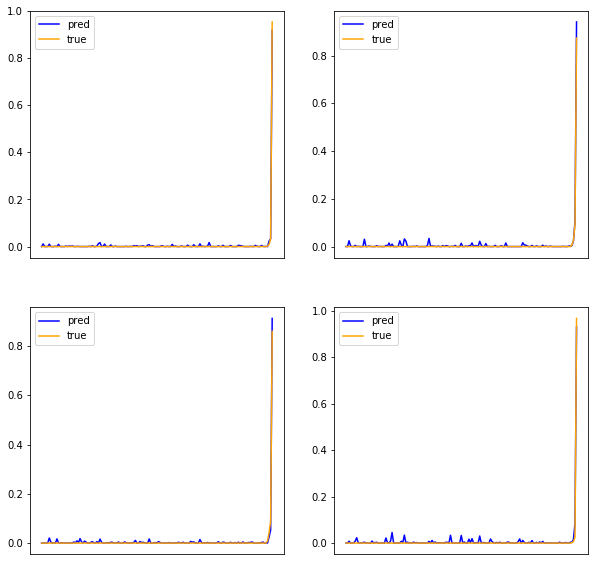

In [11]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for ax in axes.flatten():
    # Generate random index to plot
    i = np.random.randint(len(y_test_spike), size=1)[0]
    test_pred = spike_preds[i]
    true = y_test_spike.iloc[i]
    ax.plot(test_pred, color='blue', label='pred')
    ax.plot(true, color='orange', label='true')
    ax.xaxis.set_visible(False)
    ax.legend(loc="upper left")
    
plt.show()

Create a seperate mdn model to use on the rest.

In [23]:
model_non_spike = build_mdn_model()

output_is_not_end_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 0]

X = X_train.loc[output_is_not_end_idx]
y = y_train.loc[output_is_not_end_idx].drop(['Output_Is_End', 'Output_First_Zero'], axis=1)
non_spike_fit = model_non_spike.fit(x=X, y=y, batch_size=1024, epochs=25, validation_split=0.1, callbacks=[tf.keras.callbacks.TerminateOnNaN()])

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 159)]             0         
_________________________________________________________________
baselayer (Dense)            (None, 128)               20480     
_________________________________________________________________
mdn (MDN)                    (None, 4848)              625392    
Total params: 645,872
Trainable params: 645,872
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
479/479 [==============================] - 26s 54ms/step - loss: -421.1615 - val_loss: -450.0800
Epoch 2/25
479/479 [==============================] - 24s 51ms/step - loss: -467.3605 - val_loss: -464.8155
Epoch 3/25
479/479 [==============================] - 24s 51ms/step - loss: -470.0327 - val_loss: -463.4798
Epoch 4/25
479/479 [==============================] - 

In [24]:
output_is_not_end_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 0]

X_test_non_spike = X_test.loc[output_is_not_end_idx]
y_test_non_spike = y_test.loc[output_is_not_end_idx].drop(['Output_Is_End','Output_First_Zero'], axis=1)

non_spike_preds = predict_for_test(model_non_spike, X_test_non_spike, y_test_non_spike, 16)

Total time taken: 713.8454396454617. Seconds per prediction: 0.011823722788708082


In [25]:
evaluate_fit(non_spike_preds, y_test_non_spike)

,0
count,60374.000000
mean,59.828494
std,40.482187
min,0.875193
25%,31.162486
50%,51.231835
75%,81.241800
max,200.490032


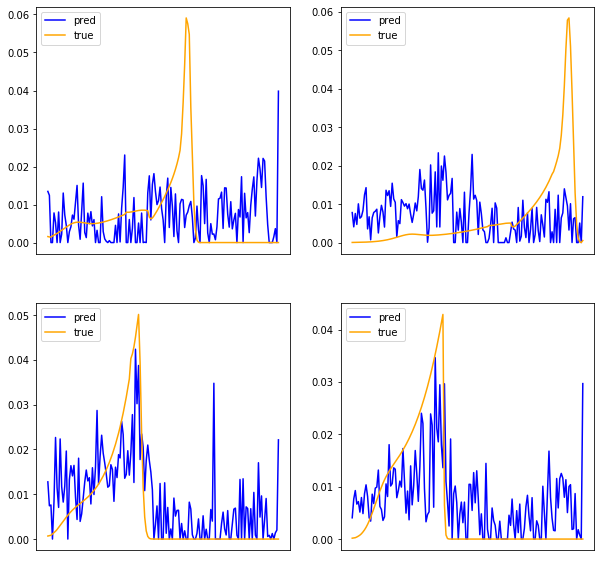

In [27]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for ax in axes.flatten():
    # Generate random index to plot
    i = np.random.randint(len(y_test_spike), size=1)[0]
    test_pred = non_spike_preds[i]
    true = y_test_non_spike.iloc[i]
    ax.plot(test_pred, color='blue', label='pred')
    ax.plot(true, color='orange', label='true')
    ax.xaxis.set_visible(False)
    ax.legend(loc="upper left")
    
plt.show()

Try to find the best tuning parameters for the neural network. The network gets stuck predicting everything as 0 (75% accuracy), but cannot improve on it.

In [ ]:
#%pip install -U keras-tuner
import kerastuner as kt

def build_model(hp):
        # Number of columns (bin count plus 8 inputs)
    l = bin_count + 8

    activation = 'selu'

    # Network
    input = tf.keras.Input(shape=(l,))

    layer =  tf.keras.layers.Dense(hp.Int('hidden_size', 16, 256, step=16, default=128), activation=hp.Choice('activation', values=['relu', 'selu', 'tanh', 'swish'], default='relu'), name='baselayer')(input)
    #layer = tf.keras.layers.Dense(1024, activation='relu', name='baselayer')(input)
    #layer_2 = tf.keras.layers.Dense(1024, activation='tanh', name='baselayer2')(layer)
    #layer_3 = tf.keras.layers.Dense(16, activation='tanh', name='baselayer3')(layer_2)
    #layer_4 = tf.keras.layers.Dense(64, activation=activation, name='baselayer4')(layer_3)
    #layer_5 = tf.keras.layers.Dense(32, activation=activation, name='baselayer5')(layer_4)
    # Connect the mdn layer to the output of our neural network
    #mdn_layer = mdn.MDN(bin_count,k, name='mdn')(layer_5)
    #model = tf.keras.models.Model(input, [mdn_layer])

    # 2 classes
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name="predictions")(layer)
    model = tf.keras.models.Model(input, [outputs])


    #opt = tf.keras.optimizers.Adam(learning_rate=1e4)
    opt = tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-2, sampling='log'))
    #model.compile(loss=mdn.get_mixture_loss_func(bin_count,k), optimizer=tf.keras.optimizers.Adam())
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner = kt.tuners.BayesianOptimization(
  build_model,
  objective='val_accuracy',
  max_trials=50)

tuner.search(x=X_train, y=y_train, batch_size=128, epochs=30, validation_split=0.1, class_weight=cweights, callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

In [5]:
preds = model.predict(X_test)
display(pd.DataFrame(preds).describe())
display(y_test.describe())

,0
count,40017.000000
mean,0.502865
std,0.064357
min,0.042015
25%,0.452332
50%,0.509930
75%,0.547307
max,0.598693


,Output_Is_End
count,40017.000000
mean,0.243771
std,0.429362
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [93]:
tuner.results_summary()

In [95]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

2394/2394 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.78 - ETA: 1s - loss: 0.6925 - accuracy: 0.75 - ETA: 1s - loss: 0.6921 - accuracy: 0.75 - ETA: 1s - loss: 0.6921 - accuracy: 0.75 - ETA: 1s - loss: 0.6921 - accuracy: 0.75 - ETA: 1s - loss: 0.6921 - accuracy: 0.75 - ETA: 1s - loss: 0.6920 - accuracy: 0.75 - ETA: 1s - loss: 0.6920 - accuracy: 0.75 - ETA: 1s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accura

In [6]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

1251/1251 [==============================] - 1s 513us/step - loss: 0.6914 - accuracy: 0.5298
Test accuracy: 0.5297748446464539


Build MDN for case when spike not at end, and also keep zero point column as a parameter.

In [5]:
def build_mdn_model(activation='sigmoid', k=16):
    """ k is the number of mixture models"""
    # Number of columns (bin count plus 9 inputs)
    l = bin_count + 9

    # Network
    input = tf.keras.Input(shape=(l,))

    layer = tf.keras.layers.Dense(256, activation=activation, name='baselayer')(input)
    layer_2 = tf.keras.layers.Dense(128, activation=activation, name='layer_2')(layer)

    # Connect the mdn layer to the output of our neural network
    mdn_layer = mdn.MDN(bin_count,k, name='mdn')(layer_2)
    model = tf.keras.models.Model(input, [mdn_layer])


    opt = tf.keras.optimizers.Adam(learning_rate=1e4)
    model.compile(loss=mdn.get_mixture_loss_func(bin_count,k), optimizer=tf.keras.optimizers.Adam())
    model.summary()
    return model

In [6]:
from scipy.stats import entropy
def predict_for_test(model, X_test, y_test, k):

    start = timer()

    # Returns the predictions of the parameters of the distributions and weights
    preds = model.predict(X_test)
    samples_list = []
    # Obtain 5 samples per prediction
    for i in range(5):
        samples_list.append(np.apply_along_axis(mdn.sample_from_output, 1, preds, bin_count, k, temp=1.0, sigma_temp=1.0))

    # Average the samples for our predicitons
    y_samples = np.mean(np.array(samples_list),axis=0)
    y_samples = y_samples.reshape(len(X_test),bin_count)
    # Convert negatives to 0
    y_samples = np.clip(y_samples,0, a_max=None)
    end = timer()
    
    print(f"Total time taken: {end-start}. Seconds per prediction: {(end-start)/len(preds)}")
    
    return y_samples

In [23]:
model_zero_col = build_mdn_model()

output_is_not_end_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 0]

X = X_train.loc[output_is_not_end_idx]
y = y_train.loc[output_is_not_end_idx].drop(['Output_First_Zero'], axis=1)
zero_col_fit = model_zero_col.fit(x=X, y=y, batch_size=1024, epochs=25, validation_split=0.1, callbacks=[tf.keras.callbacks.TerminateOnNaN()])

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 159)]             0         
_________________________________________________________________
baselayer (Dense)            (None, 128)               20480     
_________________________________________________________________
mdn (MDN)                    (None, 4848)              625392    
Total params: 645,872
Trainable params: 645,872
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
479/479 [==============================] - 26s 54ms/step - loss: -421.1615 - val_loss: -450.0800
Epoch 2/25
479/479 [==============================] - 24s 51ms/step - loss: -467.3605 - val_loss: -464.8155
Epoch 3/25
479/479 [==============================] - 24s 51ms/step - loss: -470.0327 - val_loss: -463.4798
Epoch 4/25
479/479 [==============================] - 

In [24]:
output_is_not_end_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 0]

X_test_zero_col = X_test.loc[output_is_not_end_idx]
y_test_zero_col = y_test.loc[output_is_not_end_idx].drop(['Output_First_Zero'], axis=1)

zero_col_preds = predict_for_test(model_zero_col, X_test_zero_col, y_test_zero_col, 16)

Total time taken: 713.8454396454617. Seconds per prediction: 0.011823722788708082


In [25]:
evaluate_fit(non_zero_col, y_test_zero_col)

,0
count,60374.000000
mean,59.828494
std,40.482187
min,0.875193
25%,31.162486
50%,51.231835
75%,81.241800
max,200.490032


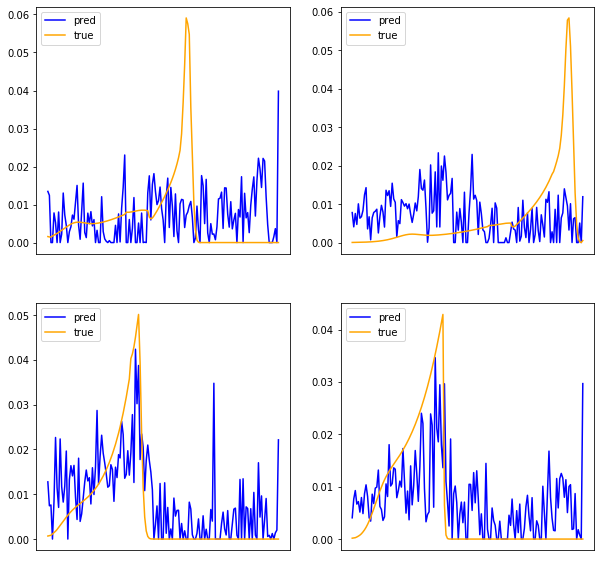

In [27]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for ax in axes.flatten():
    # Generate random index to plot
    i = np.random.randint(len(y_test_zero_col), size=1)[0]
    test_pred = zero_col_preds[i]
    true = y_test_zero_col.iloc[i]
    ax.plot(test_pred, color='blue', label='pred')
    ax.plot(true, color='orange', label='true')
    ax.xaxis.set_visible(False)
    ax.legend(loc="upper left")
    
plt.show()